In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usa-housing-dataset/usa_housing_kaggle.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

In [3]:
df= pd.read_csv("/kaggle/input/usa-housing-dataset/usa_housing_kaggle.csv")
df.head()

,Price,Bedrooms,Bathrooms,SquareFeet,YearBuilt,GarageSpaces,LotSize,ZipCode,CrimeRate,SchoolRating
0,221958,1,1.9,4827,1979,2,1.45,82240,48.60,5
1,771155,2,2.0,1035,1987,2,1.75,74315,92.03,9
2,231932,1,3.0,2769,1982,1,1.46,79249,52.08,3
3,465838,3,3.3,2708,1907,3,1.62,80587,61.65,1
4,359178,4,3.4,1175,1994,2,0.74,20756,15.66,4


First, let's get to know the dataset

In [4]:
df.shape

(300, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         300 non-null    int64  
 1   Bedrooms      300 non-null    int64  
 2   Bathrooms     300 non-null    float64
 3   SquareFeet    300 non-null    int64  
 4   YearBuilt     300 non-null    int64  
 5   GarageSpaces  300 non-null    int64  
 6   LotSize       300 non-null    float64
 7   ZipCode       300 non-null    int64  
 8   CrimeRate     300 non-null    float64
 9   SchoolRating  300 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 23.6 KB


null value check

In [6]:
df.isnull().sum()

Price           0
Bedrooms        0
Bathrooms       0
SquareFeet      0
YearBuilt       0
GarageSpaces    0
LotSize         0
ZipCode         0
CrimeRate       0
SchoolRating    0
dtype: int64

distribution of price data

<Axes: xlabel='Price', ylabel='count'>

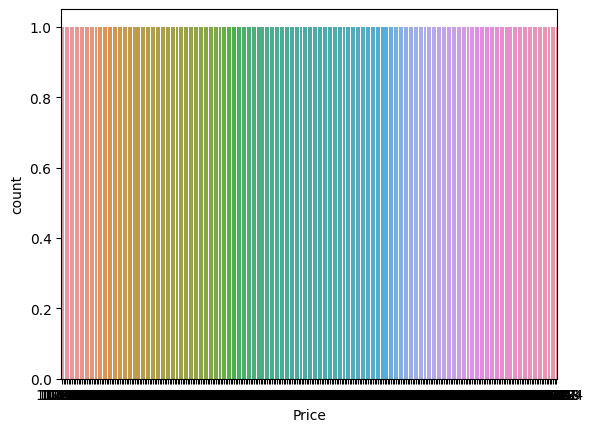

In [7]:
sns.countplot(x="Price",data=df)


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,300.0,522761.916667,256922.348275,112666.00,299936.5000,505806.500,744603.7500,999684.00
Bedrooms,300.0,2.966667,1.451175,1.00,2.0000,3.000,4.0000,5.00
Bathrooms,300.0,2.464000,0.886184,1.00,1.7000,2.400,3.2000,4.00
SquareFeet,300.0,3052.750000,1194.971440,840.00,2053.5000,3127.000,4081.0000,4997.00
YearBuilt,300.0,1962.616667,36.005431,1902.00,1931.7500,1961.000,1994.0000,2022.00
GarageSpaces,300.0,1.513333,1.116832,0.00,1.0000,1.000,3.0000,3.00
LotSize,300.0,1.062200,0.543896,0.11,0.5700,1.085,1.4825,2.00
ZipCode,300.0,54324.770000,24718.938552,10163.00,34175.0000,54896.500,74108.0000,99881.00
CrimeRate,300.0,49.324033,28.833220,0.19,22.5475,49.970,74.4025,99.71
SchoolRating,300.0,5.096667,2.674165,1.00,3.0000,5.000,8.0000,9.00


feature engineering by creating more relational data

In [9]:
df["HouseAge"] = 2025 - df["YearBuilt"]
df=df.drop(["YearBuilt"],axis=1)




In [10]:
df['Price_m2'] = df['Price'] / df['SquareFeet']


In [11]:
df["Price_per_Bedroom"] = df["Price"] / df["Bedrooms"]
df["Age_Lot_Interaction"] = df["HouseAge"] * df["LotSize"]



In [12]:
df["Crime_School_Interaction"] = df["CrimeRate"] * df["SchoolRating"]
df = df.drop(columns=["CrimeRate", "SchoolRating"])

In [13]:
df["Age_Lot_Interaction"] = df["HouseAge"] * df["LotSize"]
df = df.drop(columns=["LotSize", "HouseAge"])

Let's look at the coefficients of the columns to see their effect on the price data.

In [14]:
df=df.drop(["ZipCode"],axis=1)


<Axes: >

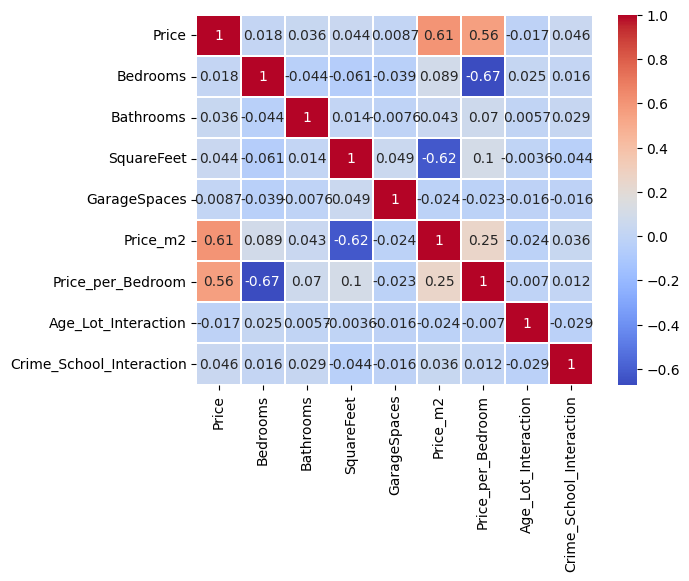

In [15]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.1)

outlier detection

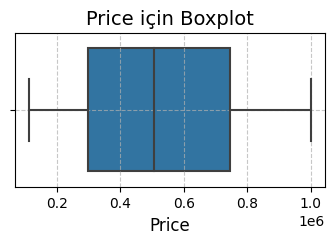

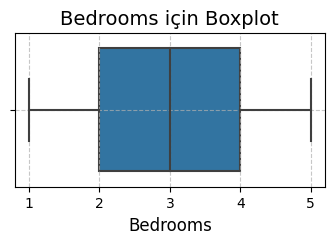

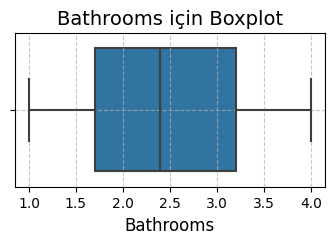

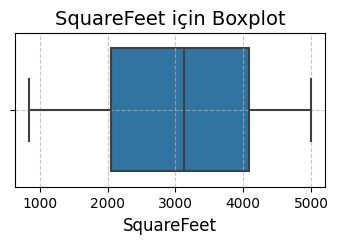

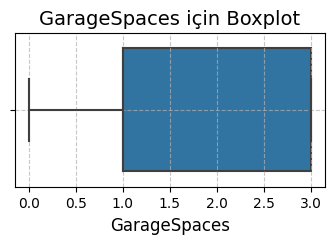

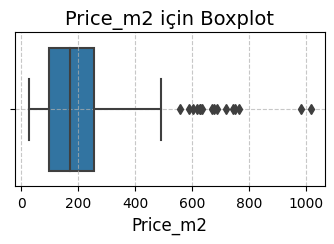

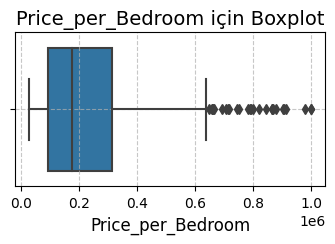

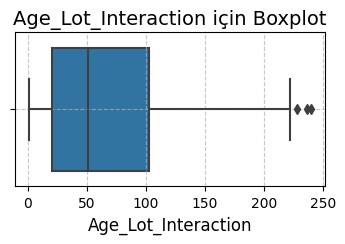

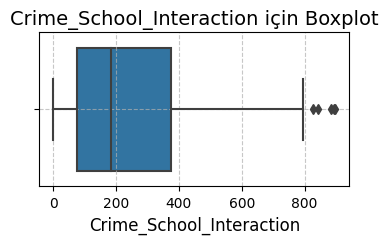

In [16]:
for col in df:
    plt.figure(figsize=(4, 2))
    sns.boxplot(x=df[col])
    plt.title(f'{col} için Boxplot', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

<Axes: xlabel='Bathrooms', ylabel='Bedrooms'>

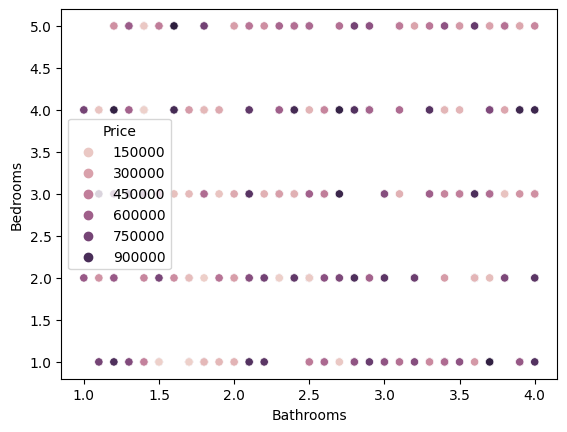

In [17]:
sns.scatterplot(x="Bathrooms" , y="Bedrooms",hue="Price", data=df)


Feature Scaling with StandardScaler

In [18]:

y=df["Price"]
x=df.drop(["Price"],axis=1)


x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)


In [19]:
df.head()

,Price,Bedrooms,Bathrooms,SquareFeet,GarageSpaces,Price_m2,Price_per_Bedroom,Age_Lot_Interaction,Crime_School_Interaction
0,221958,1,1.9,4827,2,45.982598,221958.000000,66.70,243.00
1,771155,2,2.0,1035,2,745.077295,385577.500000,66.50,828.27
2,231932,1,3.0,2769,1,83.760202,231932.000000,62.78,156.24
3,465838,3,3.3,2708,3,172.022895,155279.333333,191.16,61.65
4,359178,4,3.4,1175,2,305.683404,89794.500000,22.94,62.64


Linear Regression Model 

In [20]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
predictions = lr.predict(X_test_scaled)
lr_r2 = lr.score(X_test_scaled, y_test)
print(lr_r2)

0.7868277187625987


Random Forest Regressor Model

In [21]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest - MSE:", rf_mse)
print("Random Forest - R²:", rf_r2)

Random Forest - MSE: 3759421355.6590147
Random Forest - R²: 0.9411759349239449


XGBoost Model

In [22]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost - MSE:", xgb_mse)
print("XGBoost - R²:", xgb_r2)

XGBoost - MSE: 3012724259.904258
XGBoost - R²: 0.9528595836553279


Model Score Compare

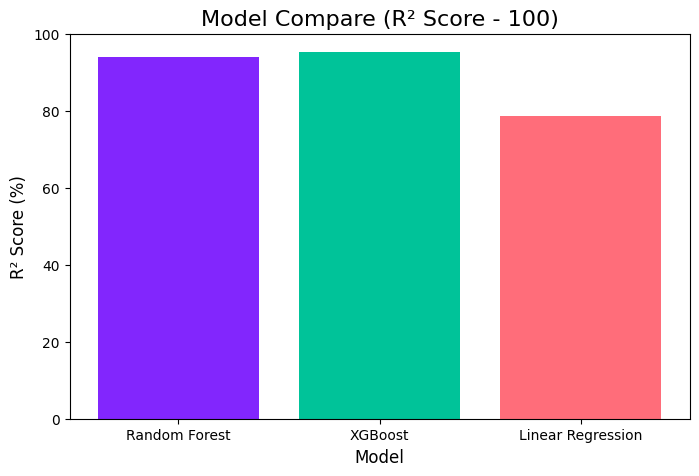

In [23]:


model_scores = {
    'Random Forest': rf_r2 * 100,
    'XGBoost': xgb_r2 * 100,
    'Linear Regression': lr_r2 * 100
}

# Grafik için hazırlık
plt.figure(figsize=(8, 5))

# Basit bir çubuk grafik oluşturma
plt.bar(model_scores.keys(), model_scores.values(), color=['#8226FD', '#00C399', '#FF6D7A'])

# Grafik başlık ve etiketler
plt.title('Model Compare (R² Score - 100)', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('R² Score (%)', fontsize=12)

# Grafiği göster
plt.show()
